In [1]:
%load_ext autoreload
%autoreload 2

In [46]:
import random
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from torchmetrics import Accuracy, Precision, Recall, F1Score, ROC, AUROC, PrecisionRecallCurve, AveragePrecision, ConfusionMatrix
from datasets import load_dataset, load_from_disk, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [6]:
from population_stability_index.psi import calculate_psi
from lift_curve import lift_curve

In [7]:
device = "mps"

# Load Dataset

In [56]:
training_data = load_dataset("imdb")["train"]
baseline_data = load_dataset("imdb")["test"]
realtime_data = load_dataset("rotten_tomatoes")["train"]

Found cached dataset imdb (/Users/chuhan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset imdb (/Users/chuhan/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

Found cached dataset rotten_tomatoes (/Users/chuhan/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46)


  0%|          | 0/3 [00:00<?, ?it/s]

In [47]:
training_data = load_from_disk("./datasets/training_data_predicted")
baseline_data = load_from_disk("./datasets/baseline_data_predicted")
realtime_data = load_from_disk("./datasets/realtime_data_predicted")

# Load Model

In [58]:
model_id = "lvwerra/distilbert-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id)

# Model Inference

In [59]:
def predict(batch):
    batch.update(tokenizer(
        text=batch["text"],
        padding=True,
        truncation=True,
        max_length=512,
        return_tensors="pt"
    ))
    with torch.no_grad():
        outputs = model.to(device)(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=torch.tensor(batch["label"], device=device),
            output_hidden_states=True
        )
        batch.update(
            score=torch.softmax(outputs.logits, dim=1)[:, 1].cpu(),
            model_embedding=outputs.hidden_states[-1][:, 0, :]
        )
    return batch

In [60]:
training_data = training_data.map(function=predict, batched=True, batch_size=16)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [61]:
baseline_data = baseline_data.map(function=predict, batched=True, batch_size=16)

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

In [62]:
realtime_data = realtime_data.map(function=predict, batched=True, batch_size=16)

Map:   0%|          | 0/8530 [00:00<?, ? examples/s]

In [63]:
realtime_data

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask', 'score', 'model_embedding'],
    num_rows: 8530
})

# Cache Processed Dataset

In [64]:
training_data.save_to_disk("./datasets/training_data_predicted")
training_data.to_json("./datasets/training_data_predicted.jsonl")

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [65]:
baseline_data.save_to_disk("./datasets/baseline_data_predicted")
baseline_data.to_json("./datasets/baseline_data_predicted.jsonl")

Saving the dataset (0/1 shards):   0%|          | 0/25000 [00:00<?, ? examples/s]

In [66]:
realtime_data.save_to_disk("./datasets/realtime_data_predicted")
realtime_data.to_json("./datasets/realtime_data_predicted.jsonl")

Saving the dataset (0/1 shards):   0%|          | 0/8530 [00:00<?, ? examples/s]

# Split Realtime Dataset

In [49]:
realtime_data_series = DatasetDict()
for i in range(shards := len(realtime_data) // 100):
    realtime_data_series[datetime.now() + timedelta(hours=i)] = realtime_data.shard(shards, i)

# Compute Metrics

In [51]:
def eval_performance(dataset):
    args = dict(preds=torch.tensor(dataset["score"]), target=torch.tensor(dataset["label"]))
    metrics = dict(
        accuracy=Accuracy(task="binary")(**args),
        precision=Precision(task="binary")(**args),
        recall=Recall(task="binary")(**args),
        f1score=F1Score(task="binary")(**args),
        confusion=ConfusionMatrix(task="binary")(**args),
        roccurve=ROC(task="binary")(**args),
        auroc=AUROC(task="binary")(**args),
        prcurve=PrecisionRecallCurve(task="binary")(**args),
        auprc=AveragePrecision(task="binary")(**args),
        lift=lift_curve(y_val=dataset["label"], y_pred=dataset["score"])
    )
    return metrics

In [68]:
training_metrics = eval_performance(training_data)
baseline_metrics = eval_performance(baseline_data)
realtime_metrics = {
    timestamp: {
        **eval_performance(data),
        "psi": calculate_psi(np.array(baseline_data["score"]), np.array(data["score"]))
    }
    for timestamp, data in realtime_data_series.items()
}

In [54]:
realtime_metrics

{datetime.datetime(2023, 5, 30, 3, 33, 10, 785767): {'accuracy': tensor(0.8879),
  'precision': tensor(0.8750),
  'recall': tensor(0.9074),
  'f1score': tensor(0.8909),
  'confusion': tensor([[46,  7],
          [ 5, 49]]),
  'roccurve': (tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189,
           0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0189, 0.0377,
           0.0377, 0.0377, 0.0566, 0.0566, 0.0566, 0.0566, 0.0566, 0.0755, 0.0943,
           0.0943, 0.0943, 0.0943, 0.1132, 0.1132, 0.1132, 0.1132, 0.1321, 0.1321,
           0.1321, 0.1321, 0.1321, 0.1509, 0.1509, 0.1698, 0.1887, 0.2075, 0.2264,
           0.2453, 0.2642, 0.2830, 0.2830, 0.3019, 0.3019, 0.3208, 0.3208, 0.3396,
           0.3585, 0.3585, 0.3774, 0.3962, 0.4151, 0.4340, 0.4528, 0.4717, 0.4906,
           0.5094

# Visualize Metrics

## Confidence Scores

In [15]:
def visualize_score(training_data, baseline_data, realtime_data, samples=200):
    training_scores = pd.DataFrame(dict(
        score=training_data["score"],
        label=training_data["label"],
        dataset="training"
    )).sample(samples)
    baseline_scores = pd.DataFrame(dict(
        score=baseline_data["score"],
        label=baseline_data["label"],
        dataset="baseline"
    )).sample(samples)
    realtime_scores = pd.DataFrame(dict(
        score=realtime_data["score"],
        label=realtime_data["label"],
        dataset="realtime"
    )).sample(samples)
    scores_df = pd.concat([training_scores, baseline_scores, realtime_scores], axis=0)
    sns.swarmplot(scores_df, x="dataset", y="score", hue="label", size=4)
    plt.title("Score Distribution")

/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 26.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 8.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/categorical.py:3544: UserWarning: 36.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/opt/homebrew/anaconda3/lib/python3.10/site-packages/seaborn/cate

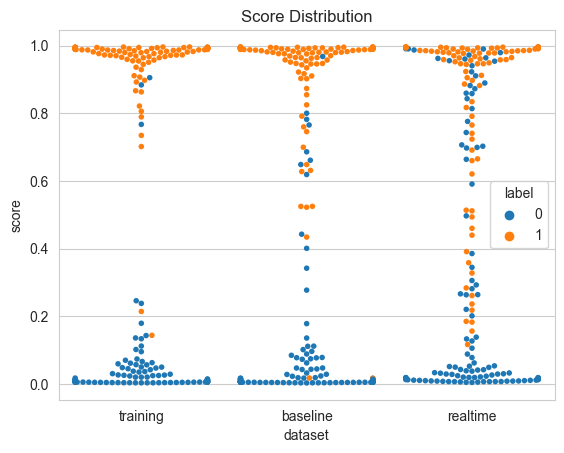

In [16]:
visualize_score(training_data, baseline_data, realtime_data)

In [129]:
def visualize_psi(initial, new):
    initial = np.array(initial)
    new = np.array(new)

    def scale_range (input, min, max):
        input += -(np.min(input))
        input /= np.max(input) / (max - min)
        input += min
        return input

    buckets = 10
    raw_breakpoints = np.arange(0, buckets + 1) / (buckets) * 100
    breakpoints = scale_range(raw_breakpoints, np.min(initial), np.max(initial))

    initial_counts = np.histogram(initial, breakpoints)[0]
    new_counts = np.histogram(new, breakpoints)[0]

    df = pd.DataFrame({'Bucket': np.arange(1, 11), 'Breakpoint Value':breakpoints[1:], 'Initial Count':initial_counts, 'New Count':new_counts})
    df['Initial Percent'] = df['Initial Count'] / len(initial)
    df['New Percent'] = df['New Count'] / len(new)

    df['New Percent'][df['New Percent'] == 0] = 0.001

    percents = (df[['Initial Percent', 'New Percent', 'Bucket']]
                .melt(id_vars=['Bucket'])
                .rename(columns={'variable':'Population', 'value':'Percent'}))
    p = sns.barplot(x="Bucket", y="Percent", hue="Population", data=percents)
    p.set(xlabel='Bucket', ylabel='Population Percent')
    sns.despine(left=True)

    psi = calculate_psi(initial, new)
    plt.title(f"PSI = {psi}")

/var/folders/4f/qvp5rtvs5jb50clr1dd373f40000gn/T/ipykernel_54561/2059454250.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



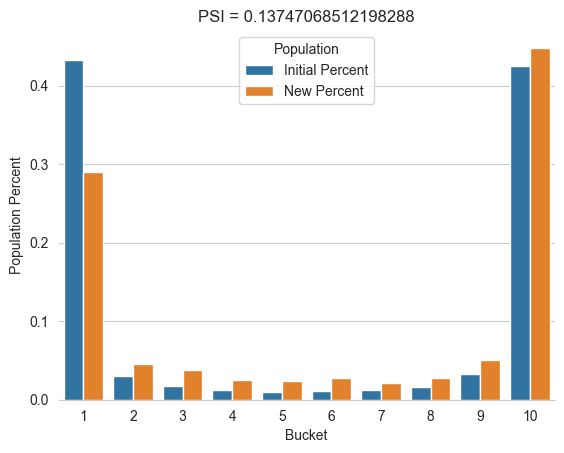

In [130]:
visualize_psi(baseline_data["score"], realtime_data["score"])

## Performance Metrics

Text(0.5, 1.0, 'Performance Metrics')

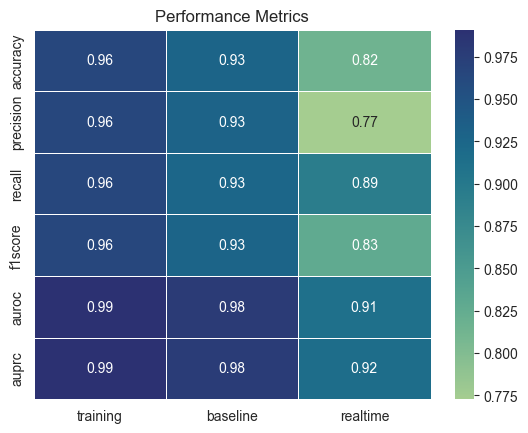

In [14]:
sns.heatmap(
    data=pd.DataFrame(dict(
        training=training_metrics,
        baseline=baseline_metrics,
        realtime=realtime_metrics
    )).loc[["accuracy", "precision", "recall", "f1score", "auroc", "auprc"]].applymap(float),
    cmap="crest",
    annot=True,
    linewidth=.5
)
plt.title("Performance Metrics")

## ROC Curve

In [17]:
def visualize_roc(training_metrics, baseline_metrics, realtime_metrics, n_samples=200):
    columns = ["false positive", "true positive", "threshold"]
    def sample_curve_df(metrics, dataset):
        df = pd.DataFrame(metrics["roccurve"], dtype=float, index=columns).T
        df = pd.concat([df.iloc[[0, -1]], df.iloc[1:-1].sample(n_samples - 2)], axis=0)
        df["dataset"] = dataset
        return df
    curve_df = pd.concat([
        sample_curve_df(metrics=metrics, dataset=dataset)
        for dataset, metrics in dict(
            training=training_metrics,
            baseline=baseline_metrics,
            realtime=realtime_metrics
        ).items()
    ], axis=0)
    sns.lineplot(curve_df, x=columns[0], y=columns[1], hue="dataset")
    plt.title("ROC Curve")
    return curve_df

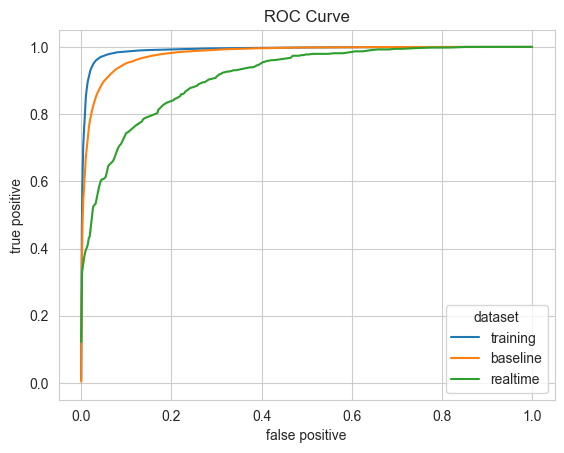

In [18]:
df = visualize_roc(training_metrics, baseline_metrics, realtime_metrics)

## Precision-Recall Curve

In [19]:
def visualize_prc(training_metrics, baseline_metrics, realtime_metrics, n_samples=200):
    columns = ["precision", "recall", "threshold"]
    def sample_curve_df(metrics, dataset):
        df = pd.DataFrame(metrics["prcurve"], dtype=float, index=columns).T
        df = pd.concat([df.iloc[[0, -1]], df.iloc[1:-1].sample(n_samples - 2)], axis=0)
        df["dataset"] = dataset
        return df
    curve_df = pd.concat([
        sample_curve_df(metrics=metrics, dataset=dataset)
        for dataset, metrics in dict(
            training=training_metrics,
            baseline=baseline_metrics,
            realtime=realtime_metrics
        ).items()
    ], axis=0)
    cond1 = (curve_df["precision"] == 0.) & (curve_df["recall"] == 0.)
    cond2 = curve_df["precision"].isna()
    curve_df.loc[cond1 | cond2, "precision"] = 1.
    sns.lineplot(curve_df, x=columns[0], y=columns[1], hue="dataset")
    plt.title("Precision-Recall Curve")

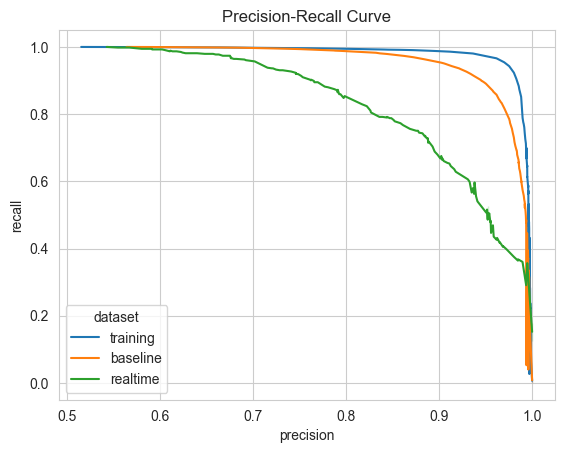

In [20]:
visualize_prc(training_metrics, baseline_metrics, realtime_metrics)

## Lift Curve

In [21]:
def visualize_lift(training_metrics, baseline_metrics, realtime_metrics, n_samples=200):
    columns = ["proportion", "lift"]
    def sample_curve_df(metrics, dataset):
        df = pd.DataFrame(metrics["lift"], dtype=float, index=columns).T
        # df = pd.concat([df.iloc[[0, -1]], df.iloc[1:-1].sample(n_samples - 2)], axis=0)
        df["dataset"] = dataset
        return df
    curve_df = pd.concat([
        sample_curve_df(metrics=metrics, dataset=dataset)
        for dataset, metrics in dict(
            training=training_metrics,
            baseline=baseline_metrics,
            realtime=realtime_metrics
        ).items()
    ], axis=0)
    sns.lineplot(curve_df, x=columns[0], y=columns[1], hue="dataset")
    plt.title("Lift Curve")

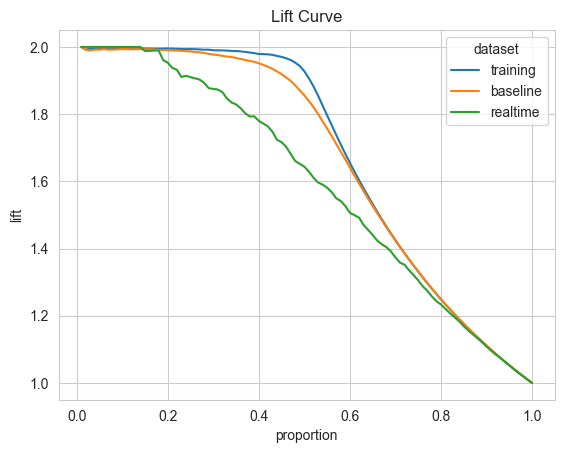

In [22]:
visualize_lift(training_metrics, baseline_metrics, realtime_metrics)

## Total Tokens

/var/folders/4f/qvp5rtvs5jb50clr1dd373f40000gn/T/ipykernel_54561/2059454250.py:22: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



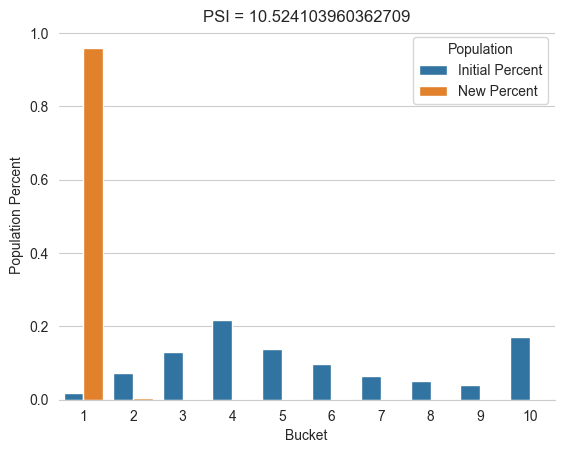

In [131]:
baseline_tokens = np.array(list(map(sum, baseline_data["attention_mask"])))
realtime_tokens = np.array(list(map(sum, realtime_data["attention_mask"])))
visualize_psi(baseline_tokens, realtime_tokens)

In [99]:
realtime_tokens

array([26,  8, 34, ..., 45, 17, 21])

## Unknown Tokens

In [53]:
unk_count = realtime_data.map(lambda x: dict(unk_count=sum(torch.tensor(x["input_ids"]) == tokenizer.unk_token_id)))["unk_count"]
np.mean(unk_count)

Loading cached processed dataset at /Users/chuhan/.cache/huggingface/datasets/rotten_tomatoes/default/1.0.0/40d411e45a6ce3484deed7cc15b82a53dad9a72aafd9f86f8f227134bec5ca46/cache-72a7abbe9a0febf9.arrow


0.0

## Embedding Similarity

In [90]:
training_embedding = training_data[0]["model_embedding"]
training_embedding

[-0.23016959428787231,
 0.14466243982315063,
 -0.05775821954011917,
 -0.38079139590263367,
 0.3192199170589447,
 -0.6269131898880005,
 0.13231277465820312,
 1.0159035921096802,
 -0.9611949920654297,
 0.2725004255771637,
 -0.40951016545295715,
 -0.2917870581150055,
 -1.413612723350525,
 0.5525525808334351,
 -0.7097678780555725,
 0.5616359114646912,
 0.3262767493724823,
 -0.10347066074609756,
 -0.12057965993881226,
 0.3202138841152191,
 -0.23248708248138428,
 -0.15191301703453064,
 0.2321927845478058,
 -0.07391563057899475,
 0.538493812084198,
 -0.512745201587677,
 0.6385754942893982,
 0.549728512763977,
 -0.272192120552063,
 -0.08563046902418137,
 0.08915001899003983,
 0.33425310254096985,
 -0.6313524842262268,
 0.07192938774824142,
 -0.17540517449378967,
 -0.042320333421230316,
 -0.2696959972381592,
 0.09532901644706726,
 -0.224842831492424,
 0.09956544637680054,
 -0.2590823769569397,
 -0.2648319900035858,
 0.3461430072784424,
 0.1348617821931839,
 0.9776914119720459,
 -0.3121834993362

In [85]:
baseline_data[0]["model_embedding"]

[-0.2670174837112427,
 0.5753251314163208,
 -0.6755527257919312,
 0.3562425673007965,
 0.3130955398082733,
 -0.41876736283302307,
 0.13943235576152802,
 0.9644359946250916,
 -0.7789989113807678,
 0.13240772485733032,
 -0.5777537226676941,
 -0.1779753565788269,
 -1.9436848163604736,
 0.9624668955802917,
 -0.4880931079387665,
 0.6671358346939087,
 0.6483597755432129,
 -0.3630511462688446,
 -0.18054704368114471,
 -0.22681327164173126,
 0.2639683783054352,
 0.7479952573776245,
 0.23505057394504547,
 0.80080646276474,
 0.5102748274803162,
 -0.5344799160957336,
 0.454529345035553,
 0.4249356985092163,
 -0.7292120456695557,
 0.5683793425559998,
 0.17049749195575714,
 -0.07209349423646927,
 0.6104874610900879,
 0.49589452147483826,
 -0.43004584312438965,
 -0.43662506341934204,
 -0.9213441014289856,
 0.2086765617132187,
 0.49384352564811707,
 -0.4455098509788513,
 0.04665595293045044,
 -0.29326918721199036,
 0.10975655913352966,
 0.01584373600780964,
 1.2304701805114746,
 -0.08847475051879883,


In [86]:
realtime_data[0]["model_embedding"]

[-0.039870500564575195,
 -0.19510525465011597,
 0.6643929481506348,
 -0.3057381510734558,
 0.14035412669181824,
 -0.13958826661109924,
 0.35944533348083496,
 0.7350451350212097,
 -0.7378271222114563,
 -0.7117151021957397,
 -0.16189083456993103,
 -0.4905824065208435,
 0.18177884817123413,
 0.2452896386384964,
 0.16414323449134827,
 -0.02938704565167427,
 0.018298910930752754,
 0.09000124782323837,
 0.13028700649738312,
 0.14082834124565125,
 -0.1728348433971405,
 -0.6987786293029785,
 -0.11592300236225128,
 -0.18749386072158813,
 -0.05263150483369827,
 -0.627498984336853,
 0.4453697204589844,
 0.12202431261539459,
 0.3182535767555237,
 -0.6226555109024048,
 -0.21216565370559692,
 0.3483467698097229,
 -0.942986011505127,
 -0.7410433888435364,
 -0.8238563537597656,
 0.3887827396392822,
 0.2870665192604065,
 -0.5875312089920044,
 -1.109581708908081,
 0.4217076301574707,
 -0.29838141798973083,
 -0.9678891897201538,
 1.355910062789917,
 -0.12446516007184982,
 -0.3802243173122406,
 -1.2440484

In [111]:
baseline_embedding = np.array(random.choices(training_data["model_embedding"], k=1000))
realtime_embedding = np.array(random.choices(realtime_data["model_embedding"], k=1000))

In [113]:
all_embedding = np.concatenate([baseline_embedding, realtime_embedding], axis=0)

In [127]:
# pca = PCA(n_components=2, random_state=2020)
# pca.fit(training_embedding)
# training_pca = pca.transform(training_embedding)
# realtime_pca = pca.transform(realtime_embedding)
tsne = TSNE(n_components=2, learning_rate='auto', init='random', perplexity=3)
all_tsne = pd.DataFrame(tsne.fit_transform(all_embedding), columns=["x", "y"])
all_tsne.loc[:1000, "dataset"] = "baseline"
all_tsne.loc[1000:, "dataset"] = "realtime"

Text(0.5, 1.0, 'Embedding Visualization')

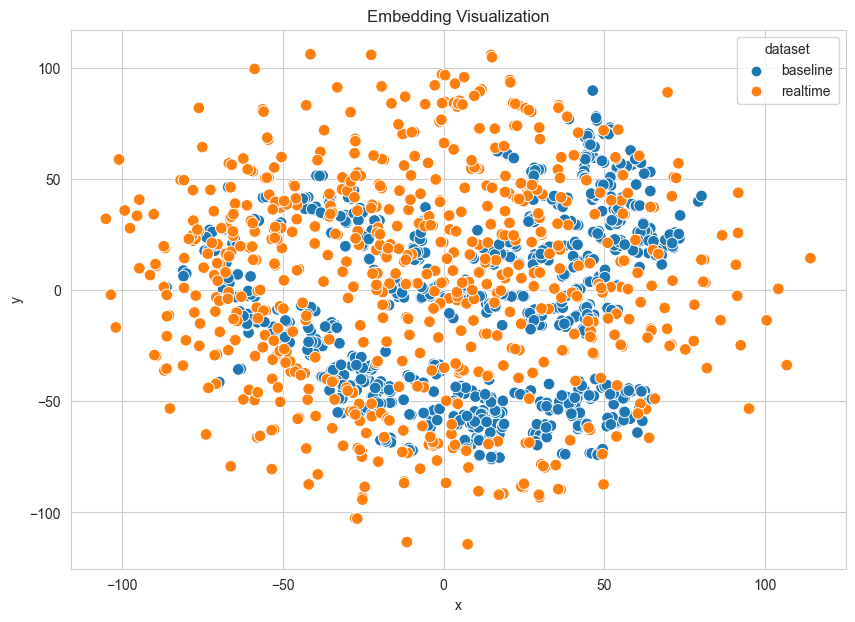

In [132]:
plt.figure(figsize=(10, 7))
sns.scatterplot(data=all_tsne, x="x", y="y", hue="dataset", s=70)
plt.title("Embedding Visualization")

In [134]:
# pca = PCA(n_components=2, random_state=2020)
# pca.fit(training_embedding)
# training_pca = pca.transform(training_embedding)
# realtime_pca = pca.transform(realtime_embedding)
tsne = TSNE(n_components=3, learning_rate='auto', init='random', perplexity=3)
all_tsne = pd.DataFrame(tsne.fit_transform(all_embedding), columns=["x", "y", "z"])
all_tsne.loc[:1000, "dataset"] = "baseline"
all_tsne.loc[1000:, "dataset"] = "realtime"

In [144]:
import plotly.express as px
fig = px.scatter_3d(all_tsne, x="x", y="y", z="z", color="dataset", size_max=1)
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0), height=800)
fig.show()